# Discrete Fourier Transform

by Felix Fritzen fritzen@mib.uni-stuttgart.de, November 2020

additional material for the course *Data Processing for Engineers and Scientists*

## Content
- trigonometric polynomials
- distance of a function to the $n$-dimensional space of the DFT(n) defined by
$$\mathcal{V}_n = \mathrm{span} \, \left\lbrace \phi_0, \dots, \phi_{n/2-1}, \phi_{-n/2}, \dots, \phi_{-1} \right\rbrace$$
- mini-examples given along the way

In [2]:
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2
from scipy.linalg import dft

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':14})

## What is done
- define trigonometric polynomials
- define a function to be considered on the interval $[0,1]$
- compute the projection (using cubature to approximate the integration)
- compute the relative distance of the function to the DFT(n) representation

Considered functions:
$$f(x) = \vert x-1/2 \vert \quad \text{and} \quad g(x) = \cos(4\pi\, x)$$

In [4]:
one_i = np.complex(0,1)
def phi(x,k,n=16):
    # index trickery:
    if ( k>=n/2):
        k=k-n
    return np.exp( -2.0*np.pi*one_i*x*k )

def cubature(fun1, fun2, N=128):
    """ compute the integral of fun1.fun2 over [0,1] using cubature on a regular grid with N points"""

    # get interval centroids
    h   = 1.0/N
    c   = np.linspace(0.0,1.0-h,N)+0.5*h

    F1 = fun1(c)
    F2 = fun2(c)
    
    I = np.sum( F1*F2.conj() )*h
    return I

def tri_poly( x, f_hat ):
    m = x.shape[0]
    n = f_hat.shape[0]
    v = np.zeros((m,n),dtype=complex)
    for i in range(n):
        v[:,i] = phi(x[:], i, n)
    # ATTENTION: the matrix product will take the complex conjugate of the matrix (here: v)
    # i.e. the coefficients have to be conjugated, as well, if this is not wanted:
    return v@f_hat.conj()

### Example: show orthonormality of phi

In [5]:
n = 4
n_cubature=4*n # WARNING: must be >= n
M = np.zeros( (n,n), dtype=complex )
for i in range(n):
    P = lambda x: phi(x, i, n)
    for j in range(i,n):
        Q = lambda x: phi(x, j, n)
        M[j,i] = M[i,j] = cubature( P, Q, N=n_cubature )

print( 'deviation of M from identity: %16.8e\n' % np.linalg.norm(M-np.identity(n)) )

deviation of M from identity:   1.96246224e-16



### Example: Verify that the FFT implementation is recovered by our phi

In [6]:
n = 16
f_hat = np.zeros(n,dtype=complex)
x = np.arange(0,n)
f = np.random.uniform(0,1,size=n)
for i in range(n):
    #PHI = np.exp(2.0*np.pi*np.complex(0,1)*x*i/n)
    PHI = phi( x/n, i, n)
    f_hat[i] = np.sum( PHI*f )
    
print('error between our DFT and the FFT: %16.8e' % np.linalg.norm(f_hat-fft(f)))
print('||f||^2, ||f_hat||^2/n             %16.8e, %16.8e' % (np.linalg.norm(f)**2, (np.linalg.norm(f_hat)**2)/n )   )
        

error between our DFT and the FFT:   9.25714809e-15
||f||^2, ||f_hat||^2/n               5.06461403e+00,   5.06461403e+00


### Example: project $f$ on DFT(n) space

$$f(x) = \left\lvert x-\frac{1}{2}\right\rvert$$

In [10]:
n            = 8
n_cubature   = 2048
f = lambda x: np.abs(x-0.5)
f_hat        = np.zeros( n, dtype=complex )
for i in range(n):
    j = i
    f_hat[i] = cubature( f, lambda x: phi( x, j, n), N=n_cubature )

norm_f = np.sqrt( cubature( f, f, N=n_cubature))

print('||f||^2           = %16.8e' % (norm_f**2))
print('||f- P_n f||^2    = %16.8e' % (norm_f**2-np.linalg.norm(f_hat)**2) )
print('||err||/||f||     = %14.8f %%' % (np.sqrt(1 - np.linalg.norm(f_hat)**2/norm_f**2)*100  ))



||f||^2           =   8.33333135e-02
||f- P_n f||^2    =   4.78858064e-05
||err||/||f||     =     2.39714375 %


### Example: project $g$ on DFT(n) space

$$g(x) = \cos(4\pi x)$$

In [11]:
g = lambda x: np.cos(4.0*np.pi*x)
g_hat        = np.zeros( n, dtype=complex )
for i in range(n):
    g_hat[i] = cubature(  lambda x: phi( x, i, n ), g, N=n_cubature )

norm_g = np.sqrt( cubature( g, g, N=n_cubature))

print('||g||^2           = %16.8e' % (norm_g**2))
print('||g- P_n g||^2    = %16.8e' % (norm_g**2-np.linalg.norm(g_hat)**2) )
print('||err||/||g||     = %14.8f %%' % (np.sqrt(1 - np.linalg.norm(g_hat)**2/norm_g**2)*100) )

||g||^2           =   5.00000000e-01
||g- P_n g||^2    =   0.00000000e+00
||err||/||g||     =     0.00000000 %


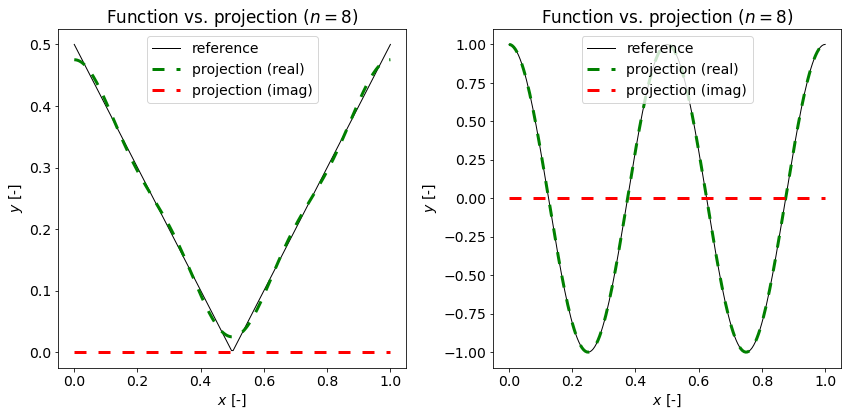

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
x = np.linspace(0,1,200)

for i in range(2):
    if (i==0):
        P = lambda x: f(x)
        y_hat = f_hat
    else:
        P = lambda x: g(x)
        y_hat = g_hat
    ax[i].plot(x, P(x), color='black', label='reference', linewidth=1)
    ax[i].plot(x, np.real(tri_poly( x, y_hat)), color='green', dashes=(4, 4), linewidth=3, label='projection (real)' )
    ax[i].plot(x, np.imag(tri_poly( x, y_hat)), color='red', dashes=(4, 4), linewidth=3, label='projection (imag)' )
    ax[i].set_title('Function vs. projection ($n=$%d)' % n,fontsize='large')
    ax[i].set_xlabel('$x$ [-]')
    ax[i].set_ylabel('$y$ [-]')
    ax[i].legend()
fig.tight_layout()


### Remarks
- cubature rule is taken as mid-point rule here
- onboarding of the negative frequencies (see definition of $\mathcal{V}_n$ and that of `phi`) is mandatory
- non-analytic functions cannot be represented 100% accurately

## Example: DFT of cosine

Show that the coefficients of the cosine are as explained in the lecture

In [28]:
n=8
x=np.arange(0,n)/n
y=np.cos(-2*np.pi*7*x)
print(fft(y))

[ 3.41076572e-15+0.00000000e+00j  4.00000000e+00+2.93575085e-15j
  9.19104080e-16+1.88737914e-15j -8.88178420e-16+3.05945349e-15j
 -5.24897388e-15+0.00000000e+00j -8.88178420e-16-3.05945349e-15j
  9.19104080e-16-1.88737914e-15j  4.00000000e+00-2.93575085e-15j]
